### GRIDSEARCH

In [29]:
import cv2
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import pandas as pd
from itertools import product
from tqdm import tqdm



# Add the 'src' directory to the Python path
sys.path.append(os.path.join(os.getcwd(), 'src'))
import Evaluator
import Utils



In [44]:


# Define image  names
#images = ["0_empty", "0","1","2","3","4","5","6","7","8","9"]
images =["1"]

# Parameters for image preprocessing
#noise_reduction = ["Gaussian", "Median","None"]
noise_reduction = ["Gaussian", "Median","None"]
filter_size = [3,5]
CLAHE = [True,False]
grid_size = [8]

# Parameters for background substraction
pct = [20,35,50]
static_foreground_removal = True

# Parameters for morphological operations
dilation=[False, True]
opening=[False, True]
closing=[False,True]
smoothing_after_morph=[False, True]

# parameters for post processing
nms_threshold = 0.5








In [31]:

# Initialize the DataFrame with specific column types
df_eval = pd.DataFrame({
    'Image': pd.Series(dtype='str'),
    'Noise Reduction': pd.Series(dtype='str'),  
    'Filter Size': pd.Series(dtype='int'),      # Or appropriate type
    'CLAHE': pd.Series(dtype='bool'),           # Or appropriate type
    'Grid Size': pd.Series(dtype='int'),       # Or appropriate type
    'Pct': pd.Series(dtype='float'),             # Or appropriate type
    'static_foreground_removal': pd.Series(dtype='bool'),
    'Dilation': pd.Series(dtype='bool'),        # Or appropriate type
    'Opening': pd.Series(dtype='bool'),         # Or appropriate type
    'Closing': pd.Series(dtype='bool'),         # Or appropriate type
    'Smoothing_after_morph': pd.Series(dtype='bool'), # Or appropriate type
    'objects_before_post_processing': pd.Series(dtype='int'),
    'objects_after_post_processing': pd.Series(dtype='int'),
    'TP': pd.Series(dtype='int'),
    'FP': pd.Series(dtype='int'),
    'FN': pd.Series(dtype='int'),
    'Precision': pd.Series(dtype='float'),
    'Recall': pd.Series(dtype='float'),
    'F1': pd.Series(dtype='float'),
    'RMSE': pd.Series(dtype='float')
})

In [32]:
# Generate all combinations of parameters using itertools.product
parameter_combinations = product(
    noise_reduction, 
    filter_size, 
    CLAHE, 
    grid_size, 
    pct, 
    [static_foreground_removal], 
    dilation, 
    opening, 
    closing, 
    smoothing_after_morph
)
# calculate the number of iterations
n_iterations = len(list(parameter_combinations))
print("Number of iterations: ", n_iterations)

Number of iterations:  576


In [33]:
def save_results_at_end(results,path):
    results_df = pd.DataFrame(results)
    # Append to CSV (set header only for the first row)
    if not os.path.exists(path):
        results_df.to_csv(path, index=False, mode='w', header=True)
    else:
        results_df.to_csv(path, index=False, mode='a', header=False)
        

In [34]:
# Function to process each parameter combination
def process_combination(params):
    image, noise, size, clahe, grid, p, static_removal, d, o, c, smooth = params
    
    # Load the image
    img = cv2.imread(f"data/images/{image}.jpg")

    # Load labels
    labels = pd.read_csv(f"data/labels/labels_{image}.csv")
    labels.columns = ['Label', 'X', 'Y', 'Image', 'Width', 'Height']
    actual_persons = len(labels)
    labels_np = labels[['X', 'Y']].to_numpy()

    # Preprocess the image
    image_preprocessed = Utils.preprocess_image(img, noise, size, clahe, grid)

    # Background subtraction
    image_no_background = Utils.background_subtraction(image_preprocessed, p, static_removal)

    # Morphological operations
    image_morph = Utils.apply_morphological_operations(image_no_background, d, o, c, smooth)

    # Segment objects with connected components
    num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(image_morph, connectivity=8)
    num_objects_before_post_processing = num_labels - 1

    # Post processing
    bounding_boxes = Utils.post_process_image(image_morph, stats, centroids, nms_threshold=0.5)

    # Evaluate the results
    eval = Evaluator.Evaluator()
    eval.evaluate_bounding_boxes(bounding_boxes, labels_np)

    # Prepare row data
    row = {
        'Image': image, 
        'Noise Reduction': noise, 
        'Filter Size': size, 
        'CLAHE': bool(clahe), 
        'Grid Size': grid, 
        'Pct': p, 
        'static_foreground_removal': bool(static_removal), 
        'Dilation': bool(d), 
        'Opening': bool(o), 
        'Closing': bool(c), 
        'Smoothing_after_morph': bool(smooth), 
        'objects_before_post_processing': num_objects_before_post_processing, 
        'objects_after_post_processing': len(bounding_boxes), 
        'TP': eval.TP, 
        'FP': eval.FP, 
        'FN': eval.FN, 
        'Precision': eval.get_precision(), 
        'Recall': eval.get_recall(), 
        'F1': eval.get_f1_score(), 
        'RMSE': eval.get_RMSE(actual_persons, eval.TP + eval.FP)
    }
    
    return row

In [35]:



# Iterate over each image and process combinations sequentially
for image in images:
    print(f"Processing image: {image}")
    parameter_combinations = product(
        noise_reduction, 
        filter_size, 
        CLAHE, 
        grid_size, 
        pct, 
        [static_foreground_removal], 
        dilation, 
        opening, 
        closing, 
        smoothing_after_morph
    )
    all_results = []
    
    # Initialize the progress bar with the total number of parameter combinations
    with tqdm(total=n_iterations, desc="Progress") as pbar:
        for params in parameter_combinations:
            result = process_combination((image, *params))
            
            if result:  # Check if result is not None
                all_results.append(result)
                #print(result)  # Optionally, print the result to track progress
            
            pbar.update(1)  # Update the progress bar for each completed combination

    # Save all results at the end
    save_results_at_end(all_results, "results_" + image + ".csv")

Processing image: 2


Progress:   0%|          | 0/576 [00:00<?, ?it/s]

Progress: 100%|██████████| 576/576 [45:15<00:00,  4.71s/it] 


Processing image: 3


Progress: 100%|██████████| 576/576 [39:03<00:00,  4.07s/it]


Processing image: 4


Progress: 100%|██████████| 576/576 [37:00<00:00,  3.85s/it]


In [45]:
# load results
df_eval = pd.read_csv("results/results_1.csv")
df_eval.head()

,Image,Noise Reduction,Filter Size,CLAHE,Grid Size,Pct,static_foreground_removal,Dilation,Opening,Closing,Smoothing_after_morph,objects_before_post_processing,objects_after_post_processing,TP,FP,FN,Precision,Recall,F1,RMSE
0,1,Gaussian,3,True,8,20,True,False,False,False,False,11144,131,12,120,10,0.090909,0.545455,0.155844,110.0
1,1,Gaussian,3,True,8,20,True,False,False,False,True,4106,394,7,389,15,0.017677,0.318182,0.033493,374.0
2,1,Gaussian,3,True,8,20,True,False,False,True,False,3837,186,3,184,19,0.016043,0.136364,0.028708,165.0
3,1,Gaussian,3,True,8,20,True,False,False,True,True,2725,356,3,354,19,0.008403,0.136364,0.015831,335.0
4,1,Gaussian,3,True,8,20,True,False,True,False,False,3245,102,13,90,9,0.126214,0.590909,0.208000,81.0


In [46]:
# get best results
best_results = df_eval.sort_values(by='F1', ascending=False).head(10)
best_results.head(10)

,Image,Noise Reduction,Filter Size,CLAHE,Grid Size,Pct,static_foreground_removal,Dilation,Opening,Closing,Smoothing_after_morph,objects_before_post_processing,objects_after_post_processing,TP,FP,FN,Precision,Recall,F1,RMSE
264,1,Median,3,False,8,35,True,True,False,False,False,3193,29,15,15,7,0.500000,0.681818,0.576923,8.0
268,1,Median,3,False,8,35,True,True,True,False,False,442,30,15,16,7,0.483871,0.681818,0.566038,9.0
78,1,Gaussian,3,False,8,35,True,True,True,True,False,114,26,13,14,9,0.481481,0.590909,0.530612,5.0
126,1,Gaussian,5,True,8,35,True,True,True,True,False,204,34,15,21,7,0.416667,0.681818,0.517241,14.0
158,1,Gaussian,5,False,8,20,True,True,True,True,False,195,39,16,24,6,0.400000,0.727273,0.516129,18.0
74,1,Gaussian,3,False,8,35,True,True,False,True,False,1001,29,13,17,9,0.433333,0.590909,0.500000,8.0
77,1,Gaussian,3,False,8,35,True,True,True,False,True,135,35,15,23,7,0.394737,0.681818,0.500000,16.0
46,1,Gaussian,3,True,8,50,True,True,True,True,False,156,36,15,23,7,0.394737,0.681818,0.500000,16.0
79,1,Gaussian,3,False,8,35,True,True,True,True,True,98,32,14,21,8,0.400000,0.636364,0.491228,13.0
271,1,Median,3,False,8,35,True,True,True,True,True,102,29,13,18,9,0.419355,0.590909,0.490566,9.0


confusion matrix: 
                  Predicted Positive  Predicted Negative
Actual Positive                  14                 121
Actual Negative                  20                   0
Precision: 0.41
Recall: 0.1037
F1 Score: 0.1657
RMSE: 121.0000


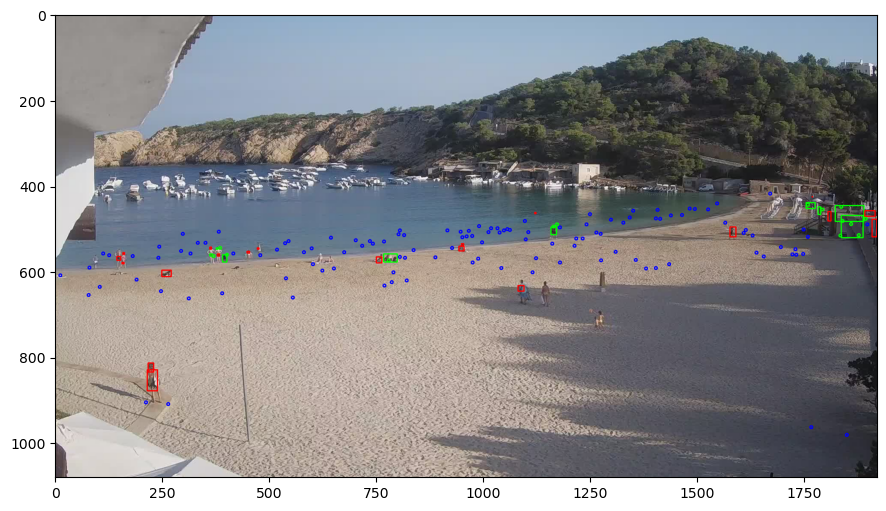

In [47]:
# get best parameters
best_params = best_results.iloc[0]
image_test = best_params['Image']
noise = best_params['Noise Reduction']
size = best_params['Filter Size']
clahe = best_params['CLAHE']
grid = best_params['Grid Size']
p = best_params['Pct']
static_foreground_removal = best_params['static_foreground_removal']
d = best_params['Dilation']
o = best_params['Opening']
c = best_params['Closing']
smooth = best_params['Smoothing_after_morph']

# Load the image
img_test = cv2.imread("data/images/" + str(image_test) + ".jpg")

# Load labels 
labels = pd.read_csv(f"data/labels/labels_{image}.csv")
labels.columns = ['Label', 'X', 'Y', 'Image', 'Width', 'Height']
actual_persons = len(labels)
labels_np = labels[['X', 'Y']].to_numpy()

# preprocess the image
image_preprocessed= Utils.preprocess_image(img_test, noise, size, clahe, grid)

# background subtraction
image_no_background = Utils.background_subtraction(image_preprocessed,p, static_foreground_removal)

# morphological operations
image_morph = Utils.apply_morphological_operations(image_no_background, d, o, c, smooth) 

# Segment objects with connected components
num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(image_morph, connectivity=8)

num_objects_before_post_processing = num_labels - 1

# post processing
bounding_boxes = Utils.post_process_image(image_morph, stats, centroids, nms_threshold)

# Evaluate the results
eval = Evaluator.Evaluator()
eval.evaluate_bounding_boxes(bounding_boxes, labels_np)

# print results
Utils.print_evaluation(eval, actual_persons)


# get bounding boxes
tp_boxes, tp_points, fp_boxes, fn_points = eval.get_bounding_boxes()

# draw result
Utils.draw_result(img_test, tp_boxes, tp_points, fp_boxes, fn_points)

In [ ]:
# load all results indiviudally filter the top 10 results and append it to the final results
final_results = []
images=["1","2","3","4","5","6","7","8","9"]
for image in images:
    df_eval = pd.read_csv("results/results_" + image + ".csv")
    best_results = df_eval.sort_values(by='F1', ascending=False).head(10)
    # add rank column
    best_results['Rank'] = range(1, len(best_results) + 1)
    final_results.append(best_results)

In [89]:
final_results_df = pd.concat(final_results)
final_results_df

,Image,Noise Reduction,Filter Size,CLAHE,Grid Size,Pct,static_foreground_removal,Dilation,Opening,Closing,...,objects_before_post_processing,objects_after_post_processing,TP,FP,FN,Precision,Recall,F1,RMSE,Rank
351,3,Median,5,False,8,20,True,True,True,True,...,161,86,96,35,38,0.732824,0.716418,0.724528,3.0,1
347,3,Median,5,False,8,20,True,True,False,True,...,201,87,96,36,38,0.727273,0.716418,0.721805,2.0,2
319,3,Median,5,True,8,35,True,True,True,True,...,181,90,95,40,39,0.703704,0.708955,0.706320,1.0,3
315,3,Median,5,True,8,35,True,True,False,True,...,195,91,95,41,39,0.698529,0.708955,0.703704,2.0,4
350,3,Median,5,False,8,20,True,True,True,True,...,173,86,90,35,44,0.720000,0.671642,0.694981,9.0,5
346,3,Median,5,False,8,20,True,True,False,True,...,220,87,90,36,44,0.714286,0.671642,0.692308,8.0,6
158,3,Gaussian,5,False,8,20,True,True,True,True,...,202,101,96,49,38,0.662069,0.716418,0.688172,11.0,7
154,3,Gaussian,5,False,8,20,True,True,False,True,...,277,103,96,51,38,0.653061,0.716418,0.683274,13.0,8
47,3,Gaussian,3,True,8,50,True,True,True,True,...,213,119,99,61,35,0.618750,0.738806,0.673469,26.0,9
43,3,Gaussian,3,True,8,50,True,True,False,True,...,267,120,99,62,35,0.614907,0.738806,0.671186,27.0,10


In [90]:
# check if there is an index which is same for all the images print me the index
final_results_df['index'] = final_results_df.index
final_results_df['index'].value_counts()













43     4
47     3
239    2
235    2
75     2
315    2
458    1
121    1
42     1
554    1
267    1
125    1
318    1
314    1
79     1
46     1
271    1
351    1
238    1
127    1
123    1
347    1
234    1
143    1
139    1
154    1
158    1
346    1
350    1
319    1
118    1
Name: index, dtype: int64

In [91]:
# filter the results for only the index 266 and 234
final_results_df = final_results_df[(final_results_df['index'] == 43)]
final_results_df

,Image,Noise Reduction,Filter Size,CLAHE,Grid Size,Pct,static_foreground_removal,Dilation,Opening,Closing,...,objects_after_post_processing,TP,FP,FN,Precision,Recall,F1,RMSE,Rank,index
43,3,Gaussian,3,True,8,50,True,True,False,True,...,120,99,62,35,0.614907,0.738806,0.671186,27.0,10,43
43,4,Gaussian,3,True,8,50,True,True,False,True,...,156,105,91,30,0.535714,0.777778,0.634441,61.0,8,43
43,5,Gaussian,3,True,8,50,True,True,False,True,...,153,127,74,44,0.631841,0.742690,0.682796,30.0,8,43
43,6,Gaussian,3,True,8,50,True,True,False,True,...,142,142,64,39,0.689320,0.784530,0.733850,25.0,1,43


In [92]:
# print parameters of index 270
print("noise_reduction: ", final_results_df['Noise Reduction'].values[0]," filter_size: ", final_results_df['Filter Size'].values[0], " clahe: ", final_results_df['CLAHE'].values[0], " grid_size: ", final_results_df['Grid Size'].values[0], " pct: ", final_results_df['Pct'].values[0], " static_foreground_removal: ", final_results_df['static_foreground_removal'].values[0], " dilation: ", final_results_df['Dilation'].values[0], " opening: ", final_results_df['Opening'].values[0], " closing: ", final_results_df['Closing'].values[0], " smoothing_after_morph: ", final_results_df['Smoothing_after_morph'].values[0])

noise_reduction:  Gaussian  filter_size:  3  clahe:  True  grid_size:  8  pct:  50  static_foreground_removal:  True  dilation:  True  opening:  False  closing:  True  smoothing_after_morph:  True
